### Import Libraries and Set the intial variables

In [ ]:
# !pip install transformers

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
import time
/
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

import seaborn as sns
# sns.set_style("whitegrid")
import matplotlib.pyplot as plt
# from matplotlib import rc
# from IPython.display import clear_output
# plt.rcParams.update({'font.size': 14})
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# подключить google drive
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

# path = r'/content/gdrive/MyDrive/project_spring/'
path_data = r'toxic_with_test.csv'
path = ""

# import sys
# sys.path.append(path)

In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = 0
# MODEL_NAME = 'DeepPavlov/rubert-base-cased'
MODEL_NAME = 'DeepPavlov/rubert-base-cased-conversational'

SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Current device {device}')

Current device cuda


### Load the data

In [ ]:
df = pd.read_csv(path_data)
df.shape

(382568, 4)

In [ ]:
# Let's have a look at the data
df.head()

,text,toxic,dataset,test
0,скотина! что сказать,1,1,0
1,я сегодня проезжала по рабочей и между домами ...,0,1,0
2,очередной лохотрон. зачем придумывать очередно...,0,1,0
3,"ретро дежавю ... сложно понять чужое сердце , ...",0,1,0
4,а когда мы статус агрогородка получили?,0,1,0


In [ ]:
# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [ ]:
%%time
# Store length of each review
token_lens = []

# Iterate through the content slide
for txt in df["text"]:
    tokens = tokenizer.encode(txt, truncation=True, max_length=512)
    token_lens.append(len(tokens))

Wall time: 2min 44s


Text(0.5, 0, 'Token count')

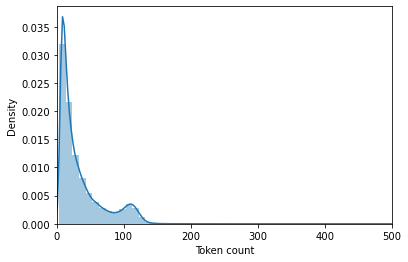

In [ ]:
# plot the distribution of review lengths
sns.distplot(token_lens)
plt.xlim([0, 500]);
plt.xlabel('Token count')

Most of the reviews seem to contain less than 120 tokens, but we’ll be on the safe side and choose a maximum length of 160.

In [ ]:
MAX_LEN = 128

### Preparing Torch Dataset

To enter data into a PyTorch, we need a more robust data generator class. We will return the review text as well to validate our predictions easily.

In [ ]:
class GPReviewDataset(Dataset):
    # Constructor Function
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    # Length magic method
    def __len__(self):
        return len(self.reviews)

    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        # Encoded format to be returned
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
df_test = df[df["test"] == 1]
df_learn = df[df["test"] == 0]
print(df_test.shape, df_learn.shape)

df_train, df_val = train_test_split(df_learn, test_size=0.1, random_state=SEED, stratify=df_learn["toxic"])
print(df_train.shape, df_val.shape, df_test.shape)

(22988, 4) (359580, 4)
(323622, 4) (35958, 4) (22988, 4)


Create a dataloader to release data in batches.

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df["text"].to_numpy(),
        targets=df["toxic"].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=NUM_WORKERS
    )

In [ ]:
# Create train, test and val data loaders
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
# Examples
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])


## Sentiment Classification with BERT and Hugging Face

We’ll use the basic BertModel and build our sentiment classifier on top of it. Let’s load the model

In [ ]:
class LoRALayer(nn.Module):
    """Wraps a linear layer with LoRA-like adapter. Wraps an existing OPT linear layer"""
    def __init__(self, module: nn.Linear, rank: int):
        super().__init__()
        self.module = module
        self.adapter = nn.Sequential(
            nn.Linear(module.in_features, rank, bias=False),
            nn.Linear(rank, module.out_features, bias=False)
        )
        nn.init.kaiming_uniform_(self.adapter[0].weight, a=5 ** 0.5)
        nn.init.zeros_(self.adapter[1].weight)

        self.adapter.to(module.weight.device)

    def forward(self, input):
        # Apply self.module and LoRA adapter, return the sum (base module outputs + adapter outputs)
        return self.module(input) + self.adapter(input)

In [ ]:
# Build the Sentiment Classifier class
class SentimentClassifier(nn.Module):

    # Constructor class
    def __init__(self, n_classes, bert_base_not_trainable=True):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        if bert_base_not_trainable:
            for param in self.bert.parameters():
                param.requires_grad = False

        for name, module in self.bert.named_modules():
            if 'BertSelfAttention' in repr(type(module)):
                module.query = LoRALayer(module.query, rank=128)
                module.key = LoRALayer(module.key, rank=128)
                module.value = LoRALayer(module.value, rank=128)

        # self.drop = nn.Dropout(p=0.3)
        if n_classes == 2:
            self.out = nn.Sequential(
              nn.Linear(self.bert.config.hidden_size, 600),
              nn.ReLU(),
              nn.BatchNorm1d(600),
              nn.Linear(600, 600),
              nn.ReLU(),
              nn.BatchNorm1d(600),
              nn.Linear(600, 300),
              nn.ReLU(),
              nn.BatchNorm1d(300),
              nn.Linear(300, 1),
              )
        else:
            self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        #  Add a dropout layer
        # output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
# Instantiate the model and move to classifier
class_names = ["normal", "toxic"]
model = SentimentClassifier(len(class_names), bert_base_not_trainable=True)
model = model.to(device)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased-conversational were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): LoRALayer(
                (module): Linear(in_features=768, out_features=768, bias=True)
                (adapter): Sequential(
                  (0): Linear(in_features=768, out_features=128, bias=False)
                  (1): Linear(in_features=128, out_features=768, bias=False)
                )
              )
              (key): LoRALayer(
                (module): Linear(in_features=768, out_features=768, bias=True)
                (adapter): Seq

In [ ]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8} - number of trainable parameters')

count_parameters(model)

   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
   98304
  460800
     600
     600
     600
  360000
     600
     600
     600
  180000
     300
     300
     300
     300
       1
________
 8083489 - number of trainable parameters


#### Model Characterstics

In [ ]:
# Number of hidden units
print(model.bert.config.hidden_size)

768


### Training Phase

we’ll use the AdamW optimizer provided by Hugging Face. It corrects weight decay. We’ll also use a linear scheduler with no warmup

In [ ]:
def weights_calc_(labels):
  s = labels.sum().detach().item()
  l = len(labels)

  if (s == l):
    return (labels / l).detach()

  if (s == 0):
    return (torch.ones(l) / l).detach()

  p = (s / l)
  n = 1 - p
  return ((labels * (n - p) + p)).detach()

def weights_calc(labels):
  return (labels * 0.6 + 0.2).detach()

# test
# labels = torch.ones(8).int()
# labels = torch.zeros(8).int()
# labels = torch.tensor([0, 0, 0, 0, 1, 0, 1, 0], dtype=torch.int32)
# weights_calc(labels)

In [ ]:
# Number of iterations
EPOCHS = 10
model_name = 'best_model_state_15a3dp_fin.bin'

# Optimizer Adam
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function
if len(class_names) == 2:
  loss_fn = nn.BCEWithLogitsLoss().to(device)
else:
  loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
r3 = lambda x: round(x, 3)
r4 = lambda x: round(x, 4)

def calc_metrics(fact, pred):
    ba = balanced_accuracy_score(fact, pred)
    pr = precision_score(fact, pred)
    rc = recall_score(fact, pred)
    f1 = f1_score(fact, pred)
    return ba, pr, rc, f1

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    y_test_list = []
    y_pred_list = []

    sm = torch.nn.Sigmoid()
    for d in data_loader:
        optimizer.zero_grad()

        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # _, preds = torch.max(outputs, dim=1)
        # loss = loss_fn(outputs, targets)
        loss_fn = torch.nn.BCEWithLogitsLoss (weight = weights_calc(targets)).to(device)
        # loss_fn = torch.nn.BCEWithLogitsLoss (pos_weight = weights_calc(targets)).to(device)

        loss = loss_fn(outputs.flatten(), targets.float())
        output_probs = sm(outputs.flatten())
        preds = (outputs > 0.5).int()
        # prediction_probs.extend(output_probs)

        y_test_list.extend(targets.tolist())
        y_pred_list.extend(preds.tolist())


        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        # Backward prop
        loss.requres_grad = True
        loss.backward()

        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        # scheduler.step()
        loss.detach()

    ba, pr, rc, f1 = calc_metrics(y_test_list, y_pred_list)
    return correct_predictions.double().cpu().item() / n_examples, np.mean(losses), ba, pr, rc, f1

Write a function to evaluate model performance

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    sm = torch.nn.Sigmoid()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        y_test_list = []
        y_pred_list = []
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            # _, preds = torch.max(outputs, dim=1)
            # loss = loss_fn(outputs, targets)
            loss_fn = torch.nn.BCEWithLogitsLoss (weight = weights_calc(targets)).to(device)
            # loss_fn = torch.nn.BCEWithLogitsLoss (pos_weight = weights_calc(targets)).to(device)

            loss = loss_fn(outputs.flatten(), targets.float())
            output_probs = sm(outputs.flatten())
            preds = (outputs > 0.5).int()
            # prediction_probs.extend(output_probs)

            y_test_list.extend(targets.tolist())
            y_pred_list.extend(preds.tolist())
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    ba, pr, rc, f1 = calc_metrics(y_test_list, y_pred_list)

    return correct_predictions.double().cpu().item() / n_examples, np.mean(losses), ba, pr, rc, f1

Write the training Loop and store the best training state.

In [ ]:
# EPOCHS = 20

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
start_time = time.time()

# нулевая эпоха
print("Метрики до начала обучения")

train_acc, train_loss, train_ba, train_pr, train_rc, train_f1 = eval_model(
    model,
    train_data_loader,
    loss_fn,
    device,
    len(df_train)
)

history['train_acc'].append(train_acc)
history['train_loss'].append(train_loss)
history['train_ba'].append(train_ba)
history['train_pr'].append(train_pr)
history['train_rc'].append(train_rc)
history['train_f1'].append(train_f1)

print(f"Train: loss {r4(train_loss)} bal_accuracy {r4(train_ba)} pr {r4(train_pr)} rc {r4(train_rc)} f1 {r4(train_f1)} time: {(time.time() - start_time)/60:.1f} min")

val_acc, val_loss, val_ba, val_pr, val_rc, val_f1 = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
)

history['val_acc'].append(val_acc)
history['val_loss'].append(val_loss)
history['val_ba'].append(val_ba)
history['val_pr'].append(val_pr)
history['val_rc'].append(val_rc)
history['val_f1'].append(val_f1)

print(f"Val: loss {r4(val_loss)} bal_accuracy {r4(val_ba)} pr {r4(val_pr)} rc {r4(val_rc)} f1 {r4(val_f1)} time: {(time.time() - start_time)/60:.1f} min")
print()

# начало обучения
for epoch in range(EPOCHS):
    # Show details
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    train_acc, train_loss, train_ba, train_pr, train_rc, train_f1 = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['train_ba'].append(train_ba)
    history['train_pr'].append(train_pr)
    history['train_rc'].append(train_rc)
    history['train_f1'].append(train_f1)

    print(f"Train: loss {r4(train_loss)} bal_accuracy {r4(train_ba)} pr {r4(train_pr)} rc {r4(train_rc)} f1 {r4(train_f1)} time: {(time.time() - start_time)/60:.1f} min")

    # Get model performance (accuracy and loss)
    val_acc, val_loss, val_ba, val_pr, val_rc, val_f1 = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    history['val_ba'].append(val_ba)
    history['val_pr'].append(val_pr)
    history['val_rc'].append(val_rc)
    history['val_f1'].append(val_f1)

    print(f"Val: loss {r4(val_loss)} bal_accuracy {r4(val_ba)} pr {r4(val_pr)} rc {r4(val_rc)} f1 {r4(val_f1)} time: {(time.time() - start_time)/60:.1f} min")
    print()

    # If we beat prev performance
    if val_f1 > best_accuracy:
        torch.save(model.state_dict(), path + model_name)
        best_accuracy = val_f1

Epoch 1/10
----------
Train loss 0.03515427244379469 accuracy 0.9671653966664812 time: 68.2 min
0.9631005009575981 0.9041538102522882 0.9556965494559706 0.9292109681029658
Val   loss 0.032369612916447285 accuracy 0.9714110907169475 time: 72.2 min
0.9662877411674884 0.9195306944773644 0.9569560927479033 0.9378701801039527

Epoch 2/10
----------
Train loss 0.03032155875546382 accuracy 0.9708456161818417 time: 141.7 min
0.9677056718176609 0.913337063009849 0.9619864609312906 0.9370307338071879
Val   loss 0.031252100647522846 accuracy 0.9736915290060626 time: 145.7 min
0.9676287710167674 0.9288622754491018 0.9565860878145042 0.9425203548426296

Epoch 3/10
----------
Train loss 0.027002567551396652 accuracy 0.9733361761561327 time: 215.4 min
0.9709211468276344 0.919365981464343 0.9665223230191575 0.9423545837759117
Val   loss 0.02999779147491003 accuracy 0.9738583903442906 time: 219.4 min
0.9695287718139054 0.9253501068122478 0.9616428219042921 0.9431474537317044

Epoch 4/10
----------
Trai

KeyboardInterrupt: 

In [ ]:
# for doc in ["val_acc", "train_acc"]:
#   for idx in range(len(history[doc])):
#     history[doc][idx] = history[doc][idx].cpu().item()

In [ ]:
# df_hist = pd.read_csv(path_hist)

In [ ]:
path_hist = path + r'history_BL_c15a3dp_fin.csv'
df_hist = pd.DataFrame.from_dict(history)
df_hist.to_csv(path_hist, encoding="utf-8", index = False)
df_hist

,train_acc,train_loss,train_ba,train_pr,train_rc,train_f1,val_acc,val_loss,val_ba,val_pr,val_rc,val_f1
0,0.774509,0.231802,0.500000,0.000000,0.000000,0.000000,0.774515,0.231787,0.500000,0.000000,0.000000,0.000000
1,0.967165,0.035154,0.963101,0.904154,0.955697,0.929211,0.971411,0.032370,0.966288,0.919531,0.956956,0.937870
2,0.970846,0.030322,0.967706,0.913337,0.961986,0.937031,0.973692,0.031252,0.967629,0.928862,0.956586,0.942520
3,0.973336,0.027003,0.970921,0.919366,0.966522,0.942355,0.973858,0.029998,0.969529,0.925350,0.961643,0.943147
4,0.976006,0.024252,0.974296,0.926019,0.971182,0.948063,0.975583,0.033447,0.966314,0.942689,0.949433,0.946049
5,0.977838,0.022106,0.976611,0.930608,0.974374,0.951988,0.975249,0.032084,0.969421,0.933253,0.958806,0.945857


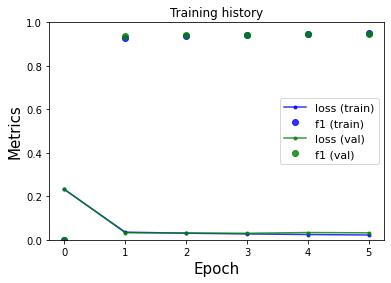

In [ ]:
# Plot training and validation
plt.plot(history['train_loss'], "b.-", label='loss (train)', alpha=0.8)
plt.plot(history['train_f1'],  "bo", label='f1 (train)', alpha=0.8)

plt.plot(history['val_loss'], "g.-", label='loss (val)', alpha=0.8)
plt.plot(history['val_f1'], "go", label='f1 (val)', alpha=0.8)

# Graph chars
plt.title('Training history')
plt.ylabel('Metrics', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(fontsize=11)
plt.ylim([0, 1]);

### Model Evaluation

In [ ]:
test_acc, test_loss, test_ba, test_pr, test_rc, test_f1 = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc

31.224290934400557

Define a helper function to get predictions from our models. This is similar to the evaluation function, except that we’re storing the text of the reviews and the predicted probabilities

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()
    sm = torch.nn.Sigmoid()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            # _, preds = torch.max(outputs, dim=1)

            output_probs = sm(outputs.flatten())
            preds = (output_probs > 0.5).int()

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(output_probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      normal       1.00      0.96      0.98     15000
       toxic       0.94      0.99      0.96      7988

    accuracy                           0.97     22988
   macro avg       0.97      0.98      0.97     22988
weighted avg       0.98      0.97      0.97     22988



Balanced Accuracy: 0.978
Precision: 0.937
Recall: 0.992
F1: 0.964
Roc Auc: 0.998


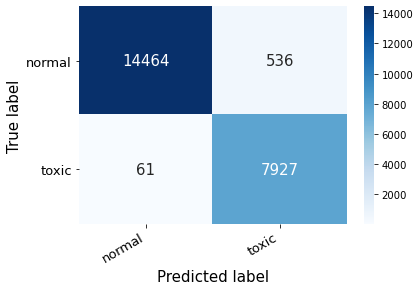

In [ ]:
def show_confusion_matrix(confusion_matrix):
    size = 15
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", annot_kws={"size": size})
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=size-2)
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right', fontsize=size-2)
    plt.ylabel('True label', fontsize=size)
    plt.xlabel('Predicted label', fontsize=size);

def output(fact, pred_probs, label_idx, threshold=0.5):
    r3 = lambda x: round(x, 3)
    pred = (pred_probs > threshold)

    print(f"Balanced Accuracy: {r3(balanced_accuracy_score(fact, pred))}")
    print(f"Precision: {r3(precision_score(fact, pred))}")
    print(f"Recall: {r3(recall_score(fact, pred))}")
    print(f"F1: {r3(f1_score(fact, pred))}")
    print(f"Roc Auc: {r3(roc_auc_score(fact, pred_probs))}")

    cm = confusion_matrix(fact, pred)
    df_cm = pd.DataFrame(cm, index=label_idx, columns=label_idx)
    show_confusion_matrix(df_cm)

output(y_test, y_pred_probs, ["normal", "toxic"])

In [ ]:
# Отрисовать precision_recall кривую
def plot_prc(y_true, y_pred_proba):
  precisions, recalls, _ = precision_recall_curve(y_true, y_pred_proba)
  plt.step(recalls, precisions, color='b', alpha=0.7, where='post')
  plt.xlabel('Recall', fontsize=15);
  plt.ylabel('Precision', fontsize=15);
  plt.plot([1, 0], [0, 1], "r--")
  plt.show()

def plot_prc_tr(y_true, y_pred_proba, rc_i_max, pr_i_max):
  precisions, recalls, _ = precision_recall_curve(y_true, y_pred_proba)
  plt.step(recalls, precisions, color='b', alpha=0.7, where='post', label="precision_recall_curve")
  plt.plot(rc_i_max, pr_i_max, "bo", alpha=0.95, label="f1_max");
  plt.xlabel('Recall', fontsize=15);
  plt.ylabel('Precision', fontsize=15);
  plt.plot([1, 0], [0, 1], "r--")
  plt.legend(fontsize=10, loc=0)
  plt.show()

def plot_roc(y_true, y_pred_proba):
    # Посчитать значения ROC кривой и значение площади под кривой AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate (FPR)', fontsize=15)
    plt.ylabel('True positive rate (TPR)', fontsize=15)
    plt.plot([0, 1], [0, 1], "r--", label="chance level (AUC = 0.5)")
    plt.show()

def plot_roc_tr(y_true, y_pred_proba, threshold):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    i_max = np.argmin(np.abs(thresholds - threshold))

    plt.plot(fpr, tpr)
    plt.plot(fpr[i_max], tpr[i_max], "bo", alpha=0.95, label="f1_max");
    plt.xlabel('False positive rate (FPR)', fontsize=15)
    plt.ylabel('True positive rate (TPR)', fontsize=15)
    plt.plot([0, 1], [0, 1], "r--", label="chance level (AUC = 0.5)")
    plt.legend(fontsize=10, loc=0)
    plt.show()

def plot_tr(threshold, pr_score_list, rc_score_list, f1_score_list, tr_i_max, f1_i_max):
    plt.plot(threshold, f1_score_list, "b-", alpha=0.7, label="f1");
    plt.plot(tr_i_max, f1_i_max, "bo", alpha=0.95, label="f1_max");
    plt.plot(threshold, pr_score_list, "g-", alpha=0.7, label="precision");
    plt.plot(threshold, rc_score_list, "r-", alpha=0.7, label="recall");
    plt.xlabel('Threshold', fontsize=15)
    plt.ylabel('Metrics score', fontsize=15)
    plt.legend(fontsize=10, loc=0)
    plt.show();

86  -  0.9735666418466121 0.9735666418466121


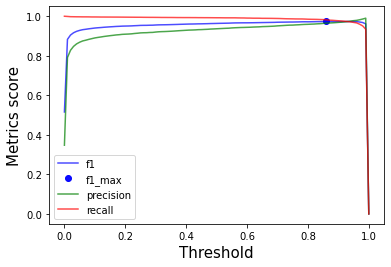

Wall time: 1.23 s


In [ ]:
%%time
f1_score_list = []
pr_score_list = []
rc_score_list = []
idx_ =  range(0, 101)
threshold =  [i / 100.0 for i in idx_]
f1_max = 0
i_max = 0

for i in idx_:
    preds_i = (y_pred_probs > threshold[i]).int()
    m = f1_score(y_test, preds_i)
    pr_score_list.append(precision_score(y_test, preds_i))
    rc_score_list.append(recall_score(y_test, preds_i))

    f1_score_list.append(m)
    if f1_max < m:
        f1_max = m
        i_max = i

print(i_max, " - ", f1_max, f1_score_list[i_max])
plot_tr(threshold, pr_score_list, rc_score_list, f1_score_list, threshold[i_max], f1_score_list[i_max])

Balanced Accuracy: 0.982
Precision: 0.965
Recall: 0.982
F1: 0.974
Roc Auc: 0.998


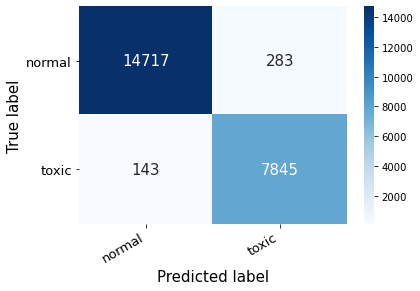

In [ ]:
output(y_test, y_pred_probs, ["normal", "toxic"], threshold[i_max])

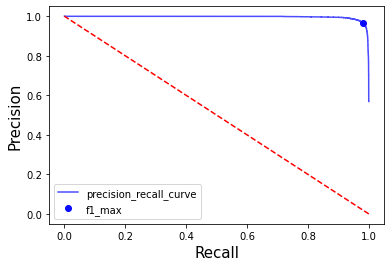

In [ ]:
plot_prc_tr(y_test, y_pred_probs, rc_score_list[i_max], pr_score_list[i_max])

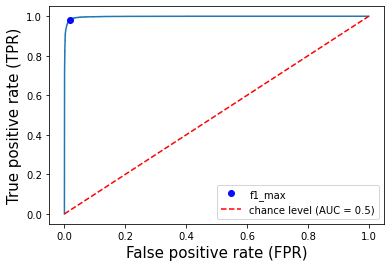

In [ ]:
plot_roc_tr(y_test, y_pred_probs, threshold[i_max])

## Predicting on raw text

In [ ]:
review_text = "ты баран"

In [ ]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
# _, prediction = torch.max(output, dim=1)
sm = torch.nn.Sigmoid()
output_probs = sm(output.flatten())
prediction = (output_probs.flatten() > 0.5).int()

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: ты баран
Sentiment  : toxic


### Анализ ошибок

In [ ]:
df_test["pred"] = y_pred
df_test["err"] = df_test["pred"] - df_test["toxic"]
df_test["err"].value_counts()

 0    22391
 1      536
-1       61
Name: err, dtype: int64

In [ ]:
num_sumples = 10
max_num = df_test[df_test["err"] == 1].shape[0]
for idx in np.random.randint(max_num, size=num_sumples):
  print(df_test[df_test["err"] == 1]["text"].iloc[idx])

В этом треде я буду ныть про баб,а анон будет либо снова звать меня омегой,делая выводы по высеру в интернете,но я и не против,ведь именно за вашим мнением я здесь Мне,знаю об этом замечательном форуме более лет.Свою,в меру активную,половую жизнь я начал с лет.Были иногда девушки,много ошибок и прочей поеботы на ошибках учатся.Пишу это в очередном истеричном припадке.У меня вопросы,достаточно банальные,но мне интересно выслушать любое мнение.Где люди знакомятся Меня нереально заебали СЗ,анон.Меня заебал инт
Ты форсы или стэн смиты никогда не носил Я вот носил,причем даже в.Они кожаные,блядь,а следовательно,дышат.Я пробовал носить и китайское гавно от фирмы асикс с дырочками,но у меня ноги охуели.
вот этого за к вконтакте в группе нашёл, но потом он сам стал писать и бесплатно давать. жаль только попки фото у меня его есть, он няшный, стройный, лвл. высокий правда, но зато удобно его стоя ебать. алсо, хуй у него см , когда жёстко ебу его, этот хуй мне снизу по яйцам постукивает иногда, 

In [ ]:
num_sumples = 10
max_num = df_test[df_test["err"] == -1].shape[0]
for idx in np.random.randint(max_num, size=num_sumples):
  print(df_test[df_test["err"] == -1]["text"].iloc[idx])

Минаев лайв на своем сайте стримил.Ютуб был как раз местом для залива записей.
мое тело мое дело так это не леваки а классические либералы. если бы "радикальная левачка", то она наоборот бы взаимно обслуживала потребности нуждающихся по указу сверху или в частном порядке по личной инициативе.
да, ее разнесло до кг от нейролептиков
Пикрил Пикрил находится в европейской части и азиатской.Покажи мне каким боком западные границы РСФСР и сама территория находится там.Что за бред.во первых ссср задумывался как равноправная федерация в условиях года.Равноправие для русских оно как бы,что то лишнее,я правильно понимаю Иначе бы нац республики просто не вошли бы в состав.АХАХАХАХАХАХАХХХ БОЖЕ КАКОЙ ЖЕ ТЫ ТУПОЙ АХУЕТЬ АХАХА Более того нац республики довольно неплохой профит приносили.Тот же хлопок или нефть.Чего в центральной россии не было.Бож
нужно заманивать таких маралистов и делать с нимми тоже самое на видео
вот что делает кровосмешение, детишки, наглядный гайд для будущих поколений.
за шай

In [ ]:
df_test[df_test["err"] == -1].sample(20)

,text,toxic,dataset,test,pred,err
271381,"анонче, давай к нам, сами ушли с окуклившегося...",1,4,1,0,-1
274716,"Вообще шмот от М Така неубиваемый,у меня штаны...",1,4,1,0,-1
301220,"да не дергайся ты за федералов так,сами разбер...",1,4,1,0,-1
269077,"вот что делает кровосмешение, детишки, наглядн...",1,4,1,0,-1
268821,"а кто такие эти ""куколды""? постоянно слышу это...",1,4,1,0,-1
271370,"и что? они не жирухи же, молодые шутливые все ...",1,4,1,0,-1
275971,"Иногда мне кажется,что весь образ Чушидзе от и...",1,4,1,0,-1
296168,окна зачем они нужны жителям огромного муравей...,1,4,1,0,-1
295890,Футбол Клоппа сильно похож по стилю на игру Гв...,1,4,1,0,-1
273292,"не способен искать информацию,не означает,что ...",1,4,1,0,-1
